###   参考 VGG 结构

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import matplotlib.pyplot as plt
import os
from PIL import Image, ImageChops
import numpy as np
import pandas as pd
import torchvision
import warnings
warnings.filterwarnings("ignore")

In [3]:
torch.cuda.empty_cache()

In [4]:
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     torch.backends.cudnn.deterministic = True
# 设置随机数种子
setup_seed(20)

In [5]:
class CNN6(nn.Module):
    def __init__(self):
        super(CNN6,self).__init__()
        
        self.conv1=nn.Sequential(
           nn.Conv2d(3,32,3,1,1),
            nn.ReLU(),   
            nn.Conv2d(32,32,3,1,1),
            nn.ReLU(),   
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2)
        )
        
        self.conv2=nn.Sequential(
            nn.Conv2d(32,64,3,1,1),
            nn.ReLU(),
            nn.Conv2d(64,64,3,1,1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2)
        )

        
        self.conv3=nn.Sequential(
            nn.Conv2d(64,128,3,1,1),
            nn.ReLU(),
            nn.Conv2d(128,128,3,1,1),
            nn.ReLU(),
            nn.Conv2d(128,128,3,1,1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2)
        )

        
        self.conv4=nn.Sequential(
            nn.Conv2d(128,256,3,1,1),
            nn.ReLU(),
            nn.Conv2d(256,256,3,1,1),
            nn.ReLU(),
            nn.Conv2d(256,256,3,1,1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2)
        )
        
        self.conv5=nn.Sequential(
            nn.Conv2d(256,256,3,1,1),
            nn.ReLU(),
            nn.Conv2d(256,256,3,1,1),
            nn.ReLU(),
            nn.Conv2d(256,256,3,1,1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2)
        )
        


        self.dense1=nn.Sequential(
            nn.Linear(8*8*256,2048),
            nn.Dropout(0.5),
            nn.ReLU()
        )
        
        self.dense2=nn.Sequential(
            nn.Linear(2048,1024),
            nn.Dropout(0.5),
            nn.ReLU()
        )
        
        self.dense3=nn.Sequential(
            nn.Linear(1024,512),
            nn.Dropout(0.5),
            nn.ReLU()
        )
       
        self.out=nn.Linear(512,101)
        
    def forward(self,x):
        x=self.conv1(x)
        x=self.conv2(x)
        x=self.conv3(x)
        x=self.conv4(x)
        x=self.conv5(x)
        x=x.view(x.size(0),-1)
        x=self.dense1(x)
        x=self.dense2(x)
        x=self.dense3(x)
        output=self.out(x)
        return output       
cnn6=CNN6().cuda()
print(cnn6)

CNN6(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(128, 12

In [6]:
EPOCH = 30
BATCH_SIZE=64
LR=0.001
optimizer=torch.optim.Adam(cnn6.parameters(),lr=LR,weight_decay=0.001)
torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, 
    verbose=False, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)
loss_func=nn.CrossEntropyLoss()


In [7]:
train_data = torchvision.datasets.ImageFolder('/kaggle/input/caltech101/Caltech101/train',transform=torchvision.transforms.Compose([
            torchvision.transforms.Resize((256,256)),torchvision.transforms.ToTensor()]))
eval_data=torchvision.datasets.ImageFolder('/kaggle/input/caltech101/Caltech101/eval',transform=torchvision.transforms.Compose([
            torchvision.transforms.Resize((256,256)),torchvision.transforms.ToTensor()]))

test_data=torchvision.datasets.ImageFolder('/kaggle/input/caltech101/Caltech101/test',transform=torchvision.transforms.Compose([
    torchvision.transforms.Resize((256,256)),torchvision.transforms.ToTensor()]))

train_loader=Data.DataLoader(dataset=train_data,batch_size=BATCH_SIZE,
                             shuffle=True, num_workers=2)
eval_loader=Data.DataLoader(dataset=eval_data,batch_size=200,
                             shuffle=True, num_workers=2)
test_loader=Data.DataLoader(dataset=test_data,batch_size=200,
                             shuffle=True, num_workers=2)

In [8]:
losses=[]
train_accs=[]
eval_accs=[]
for epoch in range(EPOCH):
    for step,(x,y) in enumerate(train_loader):
        b_x=Variable(x).cuda()
        b_y=Variable(y).cuda()
        
        output=cnn6(b_x)   #change
        loss=loss_func(output,b_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if step%10==0:
            with torch.no_grad():
                pred_y=torch.max(output,1)[1].cuda().data.squeeze()
                train_accuracy=sum(pred_y==b_y).cpu().numpy()/b_y.size(0)
                train_accs.append(train_accuracy)
                losses.append(loss.data)
                torch.cuda.empty_cache()
                eval_acc=[]
                for x,y in eval_loader:
                    b_x=Variable(x).cuda()
                    b_y=Variable(y).cuda()        
                    output=cnn6(b_x)         #change
                    pred_y=torch.max(output,1)[1].cuda().data.squeeze()
                    accuracy=sum(pred_y==b_y).cpu().numpy()/b_y.size(0)
                    eval_acc.append(accuracy)
                eval_accs.append(np.mean(eval_acc))
                print('Epoch: ',epoch,'| Step: ',step,'| loss: ',loss.data,
                      '| Train_acc: ', train_accuracy,'| Eval_acc: ', np.mean(eval_acc))

 


Epoch:  0 | Step:  0 | loss:  tensor(4.6431, device='cuda:0') | Train_acc:  0.0 | Eval_acc:  0.031999999999999994
Epoch:  0 | Step:  10 | loss:  tensor(4.4898, device='cuda:0') | Train_acc:  0.078125 | Eval_acc:  0.10700000000000001
Epoch:  0 | Step:  20 | loss:  tensor(4.4390, device='cuda:0') | Train_acc:  0.15625 | Eval_acc:  0.175
Epoch:  0 | Step:  30 | loss:  tensor(4.1010, device='cuda:0') | Train_acc:  0.125 | Eval_acc:  0.20700000000000002
Epoch:  0 | Step:  40 | loss:  tensor(3.8268, device='cuda:0') | Train_acc:  0.203125 | Eval_acc:  0.229
Epoch:  0 | Step:  50 | loss:  tensor(3.9681, device='cuda:0') | Train_acc:  0.140625 | Eval_acc:  0.246
Epoch:  0 | Step:  60 | loss:  tensor(3.5256, device='cuda:0') | Train_acc:  0.328125 | Eval_acc:  0.233
Epoch:  0 | Step:  70 | loss:  tensor(3.6197, device='cuda:0') | Train_acc:  0.21875 | Eval_acc:  0.27799999999999997
Epoch:  0 | Step:  80 | loss:  tensor(3.8278, device='cuda:0') | Train_acc:  0.1875 | Eval_acc:  0.314999999999999

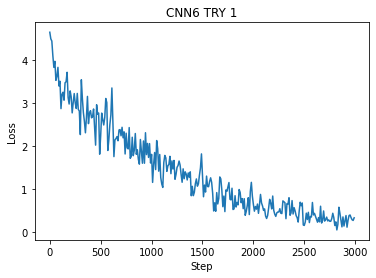

In [9]:
x=np.arange(len(losses))*10
plt.plot(x,losses)
plt.title('CNN6 TRY 1')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.show()

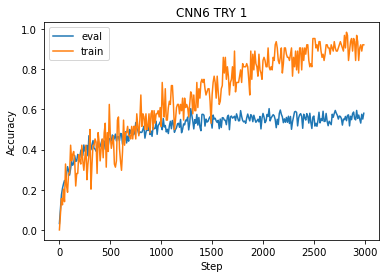

In [10]:
plt.plot(x,eval_accs,label='eval')
plt.plot(x,train_accs,label='train')
plt.title('CNN6 TRY 1')
plt.xlabel('Step')
plt.ylabel('Accuracy')
plt.legend()
plt.show()